> **Bank "churn" dataset**
<br>` 'Exited' is our classification target `
<br>` 1 - went elsewhere (nonzero is True) `
<br>` 0 - remains as a customer `

**Import the main libraries**

In [1]:
import pandas as pd
import numpy as np

from time import time

_import the local library_

In [2]:
# add parent folder path where lib folder is
import sys
if ".." not in sys.path:import sys; sys.path.insert(0, '..') 

In [3]:
from mylib import show_labels_dist, show_metrics, bias_var_metrics

**Import the Dataset**

In [4]:
## file path: unix style
data = pd.read_csv('../datasets/churn_modelling.csv')

# shape method gives the dimensions of the dataset
print('Dataset dimensions: {} rows, {} columns'.format(
    data.shape[0], data.shape[1]))

Dataset dimensions: 10000 rows, 14 columns


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
data.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


***
**Data Preparation and EDA** (unique to this dataset)
* _Check for missing values_
* _Quick visual check of unique values_
* _Split the classification feature out of the dataset_
* _Check column names of categorical attributes ( for get_dummies() )_
* _Check column names of numeric attributes ( for Scaling )_

**Check for missing values**

In [7]:
cnt=0
print('Missing Values - ')
for col in data.columns:
    nnul = pd.notnull(data[col]) 
    if (len(nnul)!=len(data)):
        cnt=cnt+1
        print('\t',col,':',(len(data)-len(nnul)),'null values')
print('Total',cnt,'features with null values')

# address missing values here

Missing Values - 
Total 0 features with null values


**Quick visual check of unique values, deal with unique identifiers**

In [8]:
# Identify columns with only one value 
# or with number of unique values == number of rows
n_eq_one = []
n_eq_all = []

print('Unique value count (',data.shape[0],'Rows in the dataset )')
for col in data.columns:
    lc = len(data[col].unique())
    print(col, ' ::> ', lc)
    if lc == 1:
        n_eq_one.append(data[col].name)
    if lc == data.shape[0]:
        n_eq_all.append(data[col].name)

Unique value count ( 10000 Rows in the dataset )
RowNumber  ::>  10000
CustomerId  ::>  10000
Surname  ::>  2932
CreditScore  ::>  460
Geography  ::>  3
Gender  ::>  2
Age  ::>  70
Tenure  ::>  11
Balance  ::>  6382
NumOfProducts  ::>  4
HasCrCard  ::>  2
IsActiveMember  ::>  2
EstimatedSalary  ::>  9999
Exited  ::>  2


In [9]:
# Drop columns with only one value
if len(n_eq_one) > 0:
    print('Dropping single-valued features')
    print(n_eq_one)
    data.drop(n_eq_one, axis=1, inplace=True)

# Drop or bin columns with number of unique values == number of rows
if len(n_eq_all) > 0:
    print('Dropping unique identifiers')
    print(n_eq_all)
    data.drop(n_eq_all, axis=1, inplace=True)

# continue with featue selection / feature engineering

Dropping unique identifiers
['RowNumber', 'CustomerId']


In [10]:
# Remove one more column that will not help predict the outcome
data.drop(['Surname'], axis=1, inplace=True)
data.head(2)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


* let's "bin" Age, Balance, and EstimatedSalary<br> 
_we could try to guess at the categories,_<br> 
_but let's use a function from our local library_

In [11]:
from mylib import autobin

In [12]:
# before we start, let's shorten one feature name))
data.rename(columns={'EstimatedSalary': 'Salary'}, inplace = True)

In [13]:
for feat in ['Age', 'Balance', 'Salary']:
    print(feat, '- minValue: ', data[feat].min(), 
          '  maxValue: ', data[feat].max())

Age - minValue:  18   maxValue:  92
Balance - minValue:  0.0   maxValue:  250898.09
Salary - minValue:  11.58   maxValue:  199992.48


In [14]:
for feat in ['Age', 'Balance', 'Salary']:
    cuts, cats = autobin(data, feat)

    newcol = feat + 'Range'
    data[newcol] = pd.cut(data[feat], bins=cuts, labels=cats) 
    
    print('Unique value count:',feat,len(data[feat].unique()),
          '  ',newcol,len(data[newcol].unique())-1,'\n')

Found 8 Bins
Unique value count: Age 70    AgeRange 8 

Found 15 Bins
Adjusted to 8 Bins
Adding a Zero bin
Unique value count: Balance 6382    BalanceRange 9 

Found 15 Bins
Adjusted to 8 Bins
Unique value count: Salary 9999    SalaryRange 8 



In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   CreditScore     10000 non-null  int64   
 1   Geography       10000 non-null  object  
 2   Gender          10000 non-null  object  
 3   Age             10000 non-null  int64   
 4   Tenure          10000 non-null  int64   
 5   Balance         10000 non-null  float64 
 6   NumOfProducts   10000 non-null  int64   
 7   HasCrCard       10000 non-null  int64   
 8   IsActiveMember  10000 non-null  int64   
 9   Salary          10000 non-null  float64 
 10  Exited          10000 non-null  int64   
 11  AgeRange        9978 non-null   category
 12  BalanceRange    9999 non-null   category
 13  SalaryRange     9999 non-null   category
dtypes: category(3), float64(2), int64(7), object(2)
memory usage: 889.9+ KB


In [16]:
data.head(2)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Salary,Exited,AgeRange,BalanceRange,SalaryRange
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,36-44,(Zero),80003-106667
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,36-44,66906-100358,106668-133331


In [17]:
data['BalanceRange'].value_counts(sort=False)

BalanceRange
(Zero)           3617
Under 33453        13
33453-66905       244
66906-100358     1351
100359-133811    2785
133812-167264    1605
167265-200717     353
200718-234170      30
Above 234170        1
Name: count, dtype: int64

In [18]:
# let's drop the detail and keep the categories
#   Using inPlace makes permanent changes to the dataframe in memory 
#   otherwise drop() will not affect the dataset we are working on
for feat in ['Age', 'Balance', 'Salary']:
    data.drop([feat], axis=1, inplace=True)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   CreditScore     10000 non-null  int64   
 1   Geography       10000 non-null  object  
 2   Gender          10000 non-null  object  
 3   Tenure          10000 non-null  int64   
 4   NumOfProducts   10000 non-null  int64   
 5   HasCrCard       10000 non-null  int64   
 6   IsActiveMember  10000 non-null  int64   
 7   Exited          10000 non-null  int64   
 8   AgeRange        9978 non-null   category
 9   BalanceRange    9999 non-null   category
 10  SalaryRange     9999 non-null   category
dtypes: category(3), int64(6), object(2)
memory usage: 655.5+ KB


**<br>Classification target feature**
<br>"the Right Answers", or more formally "the desired outcome"
<br>Must be in a separate dataset for classification ,,,

In [20]:
# this is a binary classification dataset
twoclass = True

In [21]:
## 'Exited' is our classification target 
## 1 (nonzero is True) - went elsewhere, zero - remains as a customer
print(data['Exited'].value_counts())

Exited
0    7963
1    2037
Name: count, dtype: int64


In [22]:
## Text labels look better in the confusion matrix

## a 'lambda' function is always simple, used only once
#data.Exited = data.Exited.apply(lambda x: 'Gone' if x==1 else 'Here')

## an alternative to a 'lambda' that has the same effect
data['Exited'] = ['Gone' if x==1 else 'Here' for x in data['Exited']]

## Let's change the name to 'Status' too - 'rename' is like 'drop'
## setting the parameter 'inplace' to True changes the original DataFrame 
## if not set, a new DataFrame is returned
data.rename(columns={'Exited': 'Status'}, inplace = True)

data['Status'].value_counts()

Status
Here    7963
Gone    2037
Name: count, dtype: int64

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   CreditScore     10000 non-null  int64   
 1   Geography       10000 non-null  object  
 2   Gender          10000 non-null  object  
 3   Tenure          10000 non-null  int64   
 4   NumOfProducts   10000 non-null  int64   
 5   HasCrCard       10000 non-null  int64   
 6   IsActiveMember  10000 non-null  int64   
 7   Status          10000 non-null  object  
 8   AgeRange        9978 non-null   category
 9   BalanceRange    9999 non-null   category
 10  SalaryRange     9999 non-null   category
dtypes: category(3), int64(5), object(3)
memory usage: 655.5+ KB


* Split the classification feature out of the dataset 

In [24]:
## Feature being predicted ("the Right Answer")
labels_col = 'Status'
y = data[labels_col]

## Features used for prediction 
X = data.copy()
X.drop(labels_col, axis=1, inplace=True)

**<br>Check column names of categorical attributes**
<br>Features with text values (categorical attributes) need to be normalised
<br>by changing them to numeric types that the algorithms find easier to work with

In [25]:
categori = X.select_dtypes(include=['object','category']).columns
print(categori.to_list())

['Geography', 'Gender', 'AgeRange', 'BalanceRange', 'SalaryRange']


In [26]:
# check the distribution of the feature values 
for col in categori:
    print('Distribution of categories in', col)
    print(X[col].value_counts())
    print()

Distribution of categories in Geography
Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

Distribution of categories in Gender
Gender
Male      5457
Female    4543
Name: count, dtype: int64

Distribution of categories in AgeRange
AgeRange
27-35       3589
36-44       3280
45-54       1311
18-26        998
55-63        518
64-72        210
73-81         65
Above 81       7
Name: count, dtype: int64

Distribution of categories in BalanceRange
BalanceRange
(Zero)           3617
100359-133811    2785
133812-167264    1605
66906-100358     1351
167265-200717     353
33453-66905       244
200718-234170      30
Under 33453        13
Above 234170        1
Name: count, dtype: int64

Distribution of categories in SalaryRange
SalaryRange
53339-80002      1373
80003-106667     1369
106668-133331    1340
159996-186659    1332
26675-53338      1311
133332-159995    1309
11-26674         1304
Above 186659      661
Name: count, dtype: int64



* 'one hot' encoding transforms a single column of text values into 
multiple columns of discrete values: 
it creates a new column for each unique value and puts
(one) in the column for which it is true and (zero) in the others

In [27]:
# the automatic way adds the original feature name
X = pd.get_dummies(X)

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   CreditScore                 10000 non-null  int64
 1   Tenure                      10000 non-null  int64
 2   NumOfProducts               10000 non-null  int64
 3   HasCrCard                   10000 non-null  int64
 4   IsActiveMember              10000 non-null  int64
 5   Geography_France            10000 non-null  bool 
 6   Geography_Germany           10000 non-null  bool 
 7   Geography_Spain             10000 non-null  bool 
 8   Gender_Female               10000 non-null  bool 
 9   Gender_Male                 10000 non-null  bool 
 10  AgeRange_18-26              10000 non-null  bool 
 11  AgeRange_27-35              10000 non-null  bool 
 12  AgeRange_36-44              10000 non-null  bool 
 13  AgeRange_45-54              10000 non-null  bool 
 14  AgeRang

**<br>Check column names of numeric attributes**
<br>Features with numeric values need to be normalised by changing the values to
small numbers in a specific range (scaling). _Note that scaling comes_ after _the test//train split!_

In [29]:
numeri = X.select_dtypes(include=['float64','int64']).columns
print(numeri.to_list())

['CreditScore', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']


***

**<br>Create Test // Train Datasets**
> Split X and y datasets into Train and Test subsets,<br>keeping relative proportions of each class (stratify)

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=50,
                                                   stratify=y)
# train_test_split does random selection, 
#      so we should reset the dataframe indexes
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

***
Next are standard steps for all datasets: _scaling, classifiers, results_

**Scaling** comes _after_ test // train split

In [31]:
# data before normalization
X_train.head()

,CreditScore,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,...,BalanceRange_200718-234170,BalanceRange_Above 234170,SalaryRange_11-26674,SalaryRange_26675-53338,SalaryRange_53339-80002,SalaryRange_80003-106667,SalaryRange_106668-133331,SalaryRange_133332-159995,SalaryRange_159996-186659,SalaryRange_Above 186659
0,500,6,1,1,1,True,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
1,688,6,1,1,1,True,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
2,522,5,2,1,0,False,True,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,733,9,1,1,0,True,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
4,850,2,1,1,1,True,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False


In [32]:
# scaling the Numeric columns 
# StandardScaler range: -1 to 1, MinMaxScaler range: zero to 1

# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# sklearn docs say 
#   "Don't cheat - fit only on training data, then transform both"
#   fit() expects 2D array: reshape(-1, 1) for single col or (1, -1) single row

for i in numeri:
    arr = np.array(X_train[i])
    scale = MinMaxScaler().fit(arr.reshape(-1, 1))
    X_train[i] = scale.transform(arr.reshape(len(arr),1))

    arr = np.array(X_test[i])
    X_test[i] = scale.transform(arr.reshape(len(arr),1))
    

In [33]:
# data after normalization
X_train.head()

,CreditScore,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,...,BalanceRange_200718-234170,BalanceRange_Above 234170,SalaryRange_11-26674,SalaryRange_26675-53338,SalaryRange_53339-80002,SalaryRange_80003-106667,SalaryRange_106668-133331,SalaryRange_133332-159995,SalaryRange_159996-186659,SalaryRange_Above 186659
0,0.300,0.6,0.000000,1.0,1.0,True,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
1,0.676,0.6,0.000000,1.0,1.0,True,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
2,0.344,0.5,0.333333,1.0,0.0,False,True,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,0.766,0.9,0.000000,1.0,0.0,True,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
4,1.000,0.2,0.000000,1.0,1.0,True,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False


**<br>Classifier Selection**

In [34]:
# prepare list
models = []

##  --  Linear  --  ## 
#from sklearn.linear_model import LogisticRegression 
#models.append (("LogReg",LogisticRegression())) 
#from sklearn.linear_model import SGDClassifier 
#models.append (("StocGradDes",SGDClassifier())) 
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
#models.append(("LinearDA", LinearDiscriminantAnalysis())) 
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
#models.append(("QuadraticDA", QuadraticDiscriminantAnalysis())) 

##  --  Support Vector  --  ## 
#from sklearn.svm import SVC 
#models.append(("SupportVectorClf", SVC())) 
#from sklearn.svm import LinearSVC 
#models.append(("LinearSVC", LinearSVC())) 
#from sklearn.linear_model import RidgeClassifier
#models.append (("RidgeClf",RidgeClassifier())) 

##  --  Non-linear  --  ## 
#from sklearn.tree import DecisionTreeClassifier 
#models.append (("DecisionTree",DecisionTreeClassifier())) 
#from sklearn.naive_bayes import GaussianNB 
#models.append (("GaussianNB",GaussianNB())) 
#from sklearn.neighbors import KNeighborsClassifier 
#models.append(("K-NNeighbors", KNeighborsClassifier())) 

##  --  Ensemble: bagging  --  ## 
from sklearn.ensemble import RandomForestClassifier 
models.append(("RandomForest", RandomForestClassifier())) 
##  --  Ensemble: boosting  --  ## 
#from sklearn.ensemble import AdaBoostClassifier 
#models.append(("AdaBoost", AdaBoostClassifier())) 
#from sklearn.ensemble import GradientBoostingClassifier 
#models.append(("GradientBoost", GradientBoostingClassifier())) 

##  --  NeuralNet (simplest)  --  ## 
#from sklearn.linear_model import Perceptron 
#models.append (("SingleLayerPtron",Perceptron())) 
#from sklearn.neural_network import MLPClassifier 
#models.append(("MultiLayerPtron", MLPClassifier()))

print(models)

[('RandomForest', RandomForestClassifier())]


**<br>Target Label Distributions** (standard block)

In [35]:
# from our local library
show_labels_dist(X_train,X_test,y_train,y_test)

features_train: 8000 rows, 35 columns
features_test:  2000 rows, 35 columns

labels_train: 8000 rows, 1 column
labels_test:  2000 rows, 1 column

Frequency and Distribution of labels
        Status  %_train  Status  %_test
Status                                 
Here      6370    79.62    1593   79.65
Gone      1630    20.38     407   20.35


**<br>Fit and Predict** (standard block)

In [37]:
# evaluate each model in turn
results = []

print('macro average: unweighted mean per label')
print('weighted average: support-weighted mean per label')
print('MCC: correlation between prediction and ground truth')
print('     (+1 perfect, 0 random prediction, -1 inverse)\n')

for name, clf in models:
    trs = time()
    print('Confusion Matrix:', name)
    
    clf.fit(X_train, y_train)
    ygx = clf.predict(X_test)
    results.append((name, ygx))
    
    tre = time() - trs
    print ("Run Time {} seconds".format(round(tre,2)) + '\n')
    
# Easy way to ensure that the confusion matrix rows and columns
#   are labeled exactly as the classifier has coded the classes
#   [[note the _ at the end of clf.classes_ ]]

    show_metrics(y_test, ygx, clf.classes_)   # from our local library
    print('\nParameters: ', clf.get_params(), '\n\n')

macro average: unweighted mean per label
weighted average: support-weighted mean per label
MCC: correlation between prediction and ground truth
     (+1 perfect, 0 random prediction, -1 inverse)

Confusion Matrix: RandomForest
Run Time 0.83 seconds

            pred:Gone  pred:Here
train:Gone        187        220
train:Here         77       1516

~~~~
   macro avg :  FPR = 0.294   FNR = 0.294
weighted avg :  FPR = 0.148   FNR = 0.148

~~~~
              precision    recall  f1-score   support

        Gone      0.708     0.459     0.557       407
        Here      0.873     0.952     0.911      1593

    accuracy                          0.852      2000
   macro avg      0.791     0.706     0.734      2000
weighted avg      0.840     0.852     0.839      2000

~~~~
MCC: Overall :  0.489

Parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decr

**Bias - Variance Decomposition** (standard block)

In [38]:
# from our local library
# reduce (cross-validation) folds for faster results
folds = 20
for name, clf in models:
    print('Bias // Variance Decomposition:', name)
    bias_var_metrics(X_train,X_test,y_train,y_test,clf,folds)

Bias // Variance Decomposition: RandomForest
   Average bias: 0.148
   Average variance: 0.042
   Average expected loss: 0.154  "Goodness": 0.846



***

***

In [39]:
# save our original datasets before we test the reduced ones
XtrainOriginal = X_train
XtestOriginal = X_test

**<br>_These examples only work with one classifier_<br>**

***
**Feature Importance Permutation**
<br>This can be used with any classifier or regressor to estimate feature importance.
<br>
It returns two arrays: the first array (here: `imp_vals`) contains the actual 
   importance values we are interested in. The second array is assigned to ` _ ` because we are not using it.
When `num_rounds` > 1 the permutation is repeated multiple times 
   with different random seeds, and the first array holds 
   the average of the importance values,
   with all individual values from these runs in the second array. 

In [40]:
# for graphs
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
# works best with numeric values for the target feature
from sklearn.preprocessing import LabelEncoder
## Feature being predicted ("the Right Answer")
ynum = LabelEncoder().fit_transform(y_train)

In [42]:
# note: for roc_auc_score
# we need to predict the probabilities, 
#     y_prob = clf.predict_proba(X_test)
# instead of predicting the class (like above)
#     y_pred = clf.predict(X_test)
#
# multiclass (ovr) works fine with
#     roc_auc_score(y_test, y_prob)
# but for binary classification
# output from model.predict_proba() is a matrix with 2 columns, one for each class
# to calculate roc, we need to provide the probability of the positive class:
#     roc_auc_score(y_test, y_prob[:,1])

In [43]:
# note: for feature_importance_permutation
# metric MUST be "r2" for regression 
#        or "accuracy" for classification 
#        or a custom function with signature func(y_true, y_pred)

from sklearn.metrics import roc_auc_score

def ovr_roc_auc(y_true, y_pred):
    if twoclass:
        return roc_auc_score(y_true, y_pred[:,1], 
                             average='macro')
    else:
        return roc_auc_score(y_true, y_pred,
                             multi_class='ovr',
                             average='macro')

In [44]:
# Create a list of the feature names for the graph
cols = list(X_train.columns)

In [45]:
from mlxtend.evaluate import feature_importance_permutation
clf = models[0][1]
clf.fit(X_train.values, ynum)

imp_vals, _ = feature_importance_permutation(
    predict_method=clf.predict_proba,      ## see note
    X=X_train.values,                      ## cannot use dataframe
    y=ynum,                                ## numeric labels
    metric=ovr_roc_auc,                    ## custom scorer
    num_rounds=1, seed=1)

print(imp_vals)
zz = sorted(zip(imp_vals,cols),reverse=True)
list(zz)

[2.28629696e-02 1.39453054e-02 5.99123576e-02 3.20684574e-03
 3.54442796e-02 1.68061562e-03 4.82981961e-03 2.30037272e-04
 1.15818012e-03 1.06577034e-03 6.33770261e-04 1.26081324e-02
 1.13126138e-03 1.13542198e-02 3.43124886e-03 5.34522445e-06
 0.00000000e+00 0.00000000e+00 6.17392686e-03 2.72076740e-05
 8.75461086e-05 2.11449374e-04 2.78621028e-03 7.20112490e-04
 2.26810875e-04 1.73647562e-04 0.00000000e+00 5.75358034e-04
 4.28677370e-04 6.77495160e-04 8.43486049e-04 6.11715191e-04
 6.85055523e-04 8.72379155e-04 2.43520721e-04]


[(0.059912357581069275, 'NumOfProducts'),
 (0.03544427964673369, 'IsActiveMember'),
 (0.022862969633346553, 'CreditScore'),
 (0.013945305351966253, 'Tenure'),
 (0.012608132445994014, 'AgeRange_27-35'),
 (0.011354219838005997, 'AgeRange_45-54'),
 (0.006173926861919754, 'BalanceRange_(Zero)'),
 (0.004829819610713604, 'Geography_Germany'),
 (0.003431248856314517, 'AgeRange_55-63'),
 (0.003206845739711528, 'HasCrCard'),
 (0.0027862102840191527, 'BalanceRange_100359-133811'),
 (0.0016806156157601615, 'Geography_France'),
 (0.0011581801196175467, 'Gender_Female'),
 (0.0011312613766600865, 'AgeRange_36-44'),
 (0.0010657703383382122, 'Gender_Male'),
 (0.0008723791545877102, 'SalaryRange_159996-186659'),
 (0.0008434860494457297, 'SalaryRange_80003-106667'),
 (0.0007201124904894218, 'BalanceRange_133812-167264'),
 (0.0006850555229170885, 'SalaryRange_133332-159995'),
 (0.0006774951604049395, 'SalaryRange_53339-80002'),
 (0.0006337702612899676, 'AgeRange_18-26'),
 (0.0006117151910316476, 'SalaryR

In [47]:
midf = pd.DataFrame({'Name': X_train.columns, 'Score': imp_vals})
#midf.head()

nf = 20     # number of features
# extract the top nf
mihi = midf.sort_values('Score', ascending=False).head(nf)
#mihi

#nf = 8     # number of features
# extract the low nf
#milo = midf.sort_values('Score', ascending=True).head(nf)
#milo

# merge
#hilo = pd.concat([mihi, milo])

In [48]:
#hilo

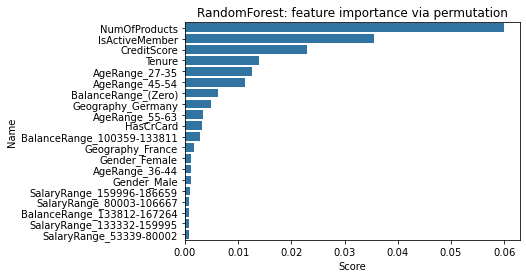

In [49]:
# quick sns.barplot
ptitle = models[0][0]
ptitle += ": feature importance via permutation"
sns.barplot(x = "Score", y = "Name", data = mihi).set(title=ptitle)
plt.show()

In [50]:
# create new dataframes with just the most important columns
rfeXtrain = X_train.filter(list(mihi['Name']))
rfeXtest = X_test.filter(list(mihi['Name']))

rfeXtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   NumOfProducts               8000 non-null   float64
 1   IsActiveMember              8000 non-null   float64
 2   CreditScore                 8000 non-null   float64
 3   Tenure                      8000 non-null   float64
 4   AgeRange_27-35              8000 non-null   bool   
 5   AgeRange_45-54              8000 non-null   bool   
 6   BalanceRange_(Zero)         8000 non-null   bool   
 7   Geography_Germany           8000 non-null   bool   
 8   AgeRange_55-63              8000 non-null   bool   
 9   HasCrCard                   8000 non-null   float64
 10  BalanceRange_100359-133811  8000 non-null   bool   
 11  Geography_France            8000 non-null   bool   
 12  Gender_Female               8000 non-null   bool   
 13  AgeRange_36-44              8000 

In [51]:
# substitute the datasets
X_train = rfeXtrain
X_test = rfeXtest

**<br>Fit and Predict** (standard block)

**Bias - Variance Decomposition** (standard block)

In [52]:
# evaluate each model in turn
results = []

print('macro average: unweighted mean per label')
print('weighted average: support-weighted mean per label')
print('MCC: correlation between prediction and ground truth')
print('     (+1 perfect, 0 random prediction, -1 inverse)\n')

for name, clf in models:
    trs = time()
    print('Confusion Matrix:', name)
    
    clf.fit(X_train, y_train)
    ygx = clf.predict(X_test)
    results.append((name, ygx))
    
    tre = time() - trs
    print ("Run Time {} seconds".format(round(tre,2)) + '\n')
    
# Easy way to ensure that the confusion matrix rows and columns
#   are labeled exactly as the classifier has coded the classes
#   [[note the _ at the end of clf.classes_ ]]

    show_metrics(y_test, ygx, clf.classes_)   # from our local library
    print('\nParameters: ', clf.get_params(), '\n\n')

macro average: unweighted mean per label
weighted average: support-weighted mean per label
MCC: correlation between prediction and ground truth
     (+1 perfect, 0 random prediction, -1 inverse)

Confusion Matrix: RandomForest
Run Time 0.85 seconds

            pred:Gone  pred:Here
train:Gone        187        220
train:Here         89       1504

~~~~
   macro avg :  FPR = 0.298   FNR = 0.298
weighted avg :  FPR = 0.154   FNR = 0.154

~~~~
              precision    recall  f1-score   support

        Gone      0.678     0.459     0.548       407
        Here      0.872     0.944     0.907      1593

    accuracy                          0.846      2000
   macro avg      0.775     0.702     0.727      2000
weighted avg      0.833     0.846     0.834      2000

~~~~
MCC: Overall :  0.471

Parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decr

In [51]:
# from our local library
# reduce (cross-validation) folds for faster results
folds = 20
for name, clf in models:
    print('Bias // Variance Decomposition:', name)
    bias_var_metrics(X_train,X_test,y_train,y_test,clf,folds)

Bias // Variance Decomposition: RandomForest
   Average bias: 0.151
   Average variance: 0.043
   Average expected loss: 0.158  "Goodness": 0.842



***
**SequentialFeatureSelector**
<br>Sequential feature selection algorithms are a family of greedy search algorithms that are used to reduce an initial d-dimensional feature space to a k-dimensional feature subspace where k < d. 
<br><br>
The motivation behind feature selection algorithms is to automatically select a subset of features most relevant to the problem. The goal of feature selection is two-fold: We want to improve the computational efficiency and reduce the model's generalization error by removing irrelevant features or noise.
<br><br>
In a nutshell, SFAs remove or add one feature at a time based on the classifier performance until a feature subset of the desired size k is reached. The 'floating' algorithms have an additional exclusion or inclusion step to remove features once they were included (or excluded) so that a larger number of feature subset combinations can be sampled.
<br><br>
http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/ 
<br>has tutorial videos, diagrams<br>
http://rasbt.github.io/mlxtend/api_subpackages/mlxtend.feature_selection/#sequentialfeatureselector <br>documents the parameters

In [53]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

***

In [ ]:
go_fwd = False
 
sfs = SFS(models[0][1], 
          k_features='parsimonious', 
          forward=go_fwd, 
          floating=True,
          cv=2,      # CVfolds
          scoring='roc_auc_ovr',
          verbose=0, 
          n_jobs= -1)

sfs = sfs.fit(X_train, y_train)

In [ ]:
#import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

if go_fwd:
    plt.title('Sequential [Forward] Selection (w. StdDev)')
else:
    plt.title('Sequential [Backward] Selection (w. StdDev)')
    
#plt.ylim([0.8, 1])
plt.grid()
plt.show()

In [56]:
sfs.k_feature_idx_

(0, 1, 3, 6, 7, 8, 9, 14)

In [57]:
sfs.k_feature_names_

('NumOfProducts',
 'IsActiveMember',
 'AgeRange_45-54',
 'BalanceRange_(Zero)',
 'Geography_Germany',
 'AgeRange_55-63',
 'BalanceRange_100359-133811',
 'AgeRange_36-44')

In [58]:
# uncomment the line below to see a dataframe of all of the details
#pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [59]:
# create new dataframes with just those columns
sfsXtrain = X_train.filter(sfs.k_feature_names_)
sfsXtest = X_test.filter(sfs.k_feature_names_)

sfsXtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   NumOfProducts               8000 non-null   float64
 1   IsActiveMember              8000 non-null   float64
 2   AgeRange_45-54              8000 non-null   bool   
 3   BalanceRange_(Zero)         8000 non-null   bool   
 4   Geography_Germany           8000 non-null   bool   
 5   AgeRange_55-63              8000 non-null   bool   
 6   BalanceRange_100359-133811  8000 non-null   bool   
 7   AgeRange_36-44              8000 non-null   bool   
dtypes: bool(6), float64(2)
memory usage: 172.0 KB


In [60]:
# substitute the datasets
X_train = sfsXtrain
X_test = sfsXtest

**<br>Fit and Predict** (standard block)

In [61]:
# evaluate each model in turn
results = []

print('macro average: unweighted mean per label')
print('weighted average: support-weighted mean per label')
print('MCC: correlation between prediction and ground truth')
print('     (+1 perfect, 0 random prediction, -1 inverse)\n')

for name, clf in models:
    trs = time()
    print('Confusion Matrix:', name)
    
    clf.fit(X_train, y_train)
    ygx = clf.predict(X_test)
    results.append((name, ygx))
    
    tre = time() - trs
    print ("Run Time {} seconds".format(round(tre,2)) + '\n')
    
# Easy way to ensure that the confusion matrix rows and columns
#   are labeled exactly as the classifier has coded the classes
#   [[note the _ at the end of clf.classes_ ]]

    show_metrics(y_test, ygx, clf.classes_)   # from our local library
    print('\nParameters: ', clf.get_params(), '\n\n')

macro average: unweighted mean per label
weighted average: support-weighted mean per label
MCC: correlation between prediction and ground truth
     (+1 perfect, 0 random prediction, -1 inverse)

Confusion Matrix: RandomForest
Run Time 0.33 seconds

            pred:Gone  pred:Here
train:Gone        183        224
train:Here         61       1532

~~~~
   macro avg :  FPR = 0.294   FNR = 0.294
weighted avg :  FPR = 0.142   FNR = 0.142

~~~~
              precision    recall  f1-score   support

        Gone      0.750     0.450     0.562       407
        Here      0.872     0.962     0.915      1593

    accuracy                          0.858      2000
   macro avg      0.811     0.706     0.739      2000
weighted avg      0.848     0.858     0.843      2000

~~~~
MCC: Overall :  0.506

Parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decr

**Bias - Variance Decomposition** (standard block)

In [62]:
# from our local library
# reduce (cross-validation) folds for faster results
folds = 20
for name, clf in models:
    print('Bias // Variance Decomposition:', name)
    bias_var_metrics(X_train,X_test,y_train,y_test,clf,folds)

Bias // Variance Decomposition: RandomForest
   Average bias: 0.142
   Average variance: 0.016
   Average expected loss: 0.145  "Goodness": 0.855

